In [2]:
import sys

sys.path.insert(1, '../')

#from feature_extraction.variational_autoencoder.vae_feature_extractor import Vae_Feature_Extractor
from feature_extraction.variational_autoencoder.vae_feature_extractor_torch import Vae_Feature_Extractor
from feature_prediction.long_short_term_memory.lstm_prediction_model import Lstm_prediction_model
from feature_prediction.deep_transformer.deep_transformer import Transformer_prediction_model, iv_grids_to_call_grids, black_scholes_call
from arbitrage_free_ivs.nsa_ivs_dnn import NSA_IVS_DNN
#from arbitrage_free_ivs.nsa_ivs_dnn_torch import NSA_IVS_DNN
from arbitrage_free_ivs.plot_ivs import IV_Plotting_Helper
from feature_prediction.plot.plot_helper_functions import plot_features_with_prediction

import matplotlib.pyplot as plt
import numpy as np
import torch

In [7]:
test_id = 2
strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)

"""
test_id 2: aplha, beta, rho, S0, V0 = [0.6, 0.7, -0.6, 1., 0.1] + eps_i \sim N(0,0.005) 
and alpha_i + 0.1 * cos(i/200), beta_i + 0.05 * cos(i/200)
"""

iv_data = np.genfromtxt(f"../data/test{test_id}_data_sabr_train.csv", delimiter=',').reshape((10000, 12, 16, 1)).astype('float32')

In [8]:
call_data = np.genfromtxt(f"../data/test{test_id}_call_data_sabr_train.csv", delimiter=',').reshape((10000, 12, 16)).astype('float32')

# Feature Extraction: VAE

In [9]:
feature_dim = 4

feature_extractor = Vae_Feature_Extractor(
    file_name = f"../data/test{test_id}_data_sabr_train.csv", 
    shape = (10000, 12, 16, 1),
    params = {
        "feature_dim": feature_dim,
        "batch_size": 32,
        "beta": 0.01,
    }
)

In [32]:
# train vae
history = feature_extractor.train(300)
# save vae
#feature_extractor.save_model(f"vae_{test_id}_")

Epoch: 0 Reconstruction Loss: 33.04784561843872 KL Loss: 5765.567455718994 Total Loss: 5798.615301337433
Epoch: 1 Reconstruction Loss: 6.183551495361328 KL Loss: 9.548963320922851 Total Loss: 15.73251481628418
Epoch: 2 Reconstruction Loss: 4.234960459899902 KL Loss: 6.890699297332763 Total Loss: 11.125659757232665
Epoch: 3 Reconstruction Loss: 3.5415709545135496 KL Loss: 7.277185284423828 Total Loss: 10.818756238937377
Epoch: 4 Reconstruction Loss: 3.179153988647461 KL Loss: 6.334824641418457 Total Loss: 9.513978630065917
Epoch: 5 Reconstruction Loss: 2.255710705947876 KL Loss: 6.188572161865235 Total Loss: 8.444282867813111
Epoch: 6 Reconstruction Loss: 1.7441957347869872 KL Loss: 6.540591381072998 Total Loss: 8.284787115859984
Epoch: 7 Reconstruction Loss: 1.3537187562942505 KL Loss: 7.031477640533447 Total Loss: 8.385196396827698
Epoch: 8 Reconstruction Loss: 1.169802762413025 KL Loss: 6.783466027069092 Total Loss: 7.953268789482117
Epoch: 9 Reconstruction Loss: 1.097643533706665 KL

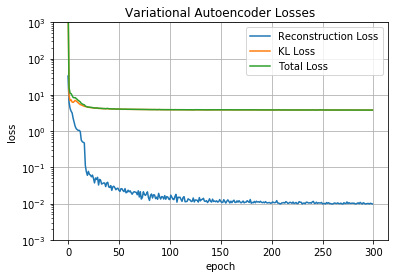

In [33]:
from matplotlib import pyplot as plt

"""
beta=0.1
Reconstruction Loss: 0.134 KL Loss: 2.13 Total Loss: 
4.6%
beta=0.001
Reconstruction Loss: 0.0068 KL Loss: 7.67 Total Loss: 7.67 
1.36%
beta=0.01
Reconstruction Loss: 0.0097 KL Loss: 3.79 Total Loss: 3.80
"""

plt.plot(history)
plt.title('Variational Autoencoder Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Reconstruction Loss','KL Loss', 'Total Loss'], loc='upper right')
plt.grid()
plt.yscale("log")
plt.ylim(1e-3,1e3)

#plt.show()
plt.savefig("vae_losses_0_01.pdf")

In [10]:
# load vae
feature_extractor.load_model(f"vae_{test_id}_")

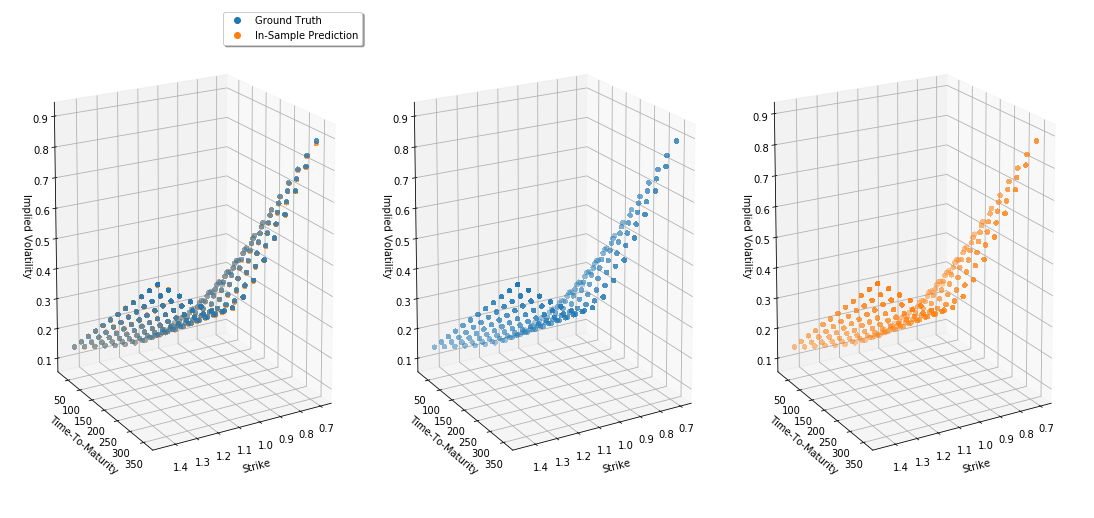

In [11]:
ind = 3208

z = feature_extractor.autoencoder.encoder(torch.from_numpy(iv_data))
rec = feature_extractor.autoencoder.decoder(z).detach().numpy()

strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)

plot_data = {
    "iv_grid_1": iv_data[ind:ind+1],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_grid_2": rec[ind:ind+1],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms,
    "legend": ["Ground Truth","In-Sample Prediction"]
}

Plt = IV_Plotting_Helper(data=plot_data)

fig = Plt.plot_all_in_one(ind = 0, view_angle=(15, 60))

8366
3837


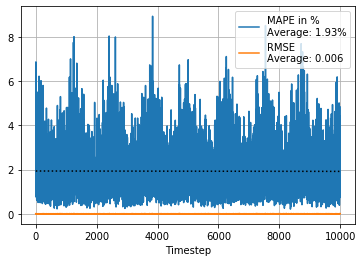

In [12]:
true_ivs = iv_data[:,:,:,0]
predicted_ivs = rec[:,:,:,0]

mape = np.mean(np.abs(true_ivs-predicted_ivs)/ true_ivs, axis=(1,2))*100
rmse = np.sqrt(np.mean(np.power(true_ivs-predicted_ivs,2), axis=(1,2)))

x_ = np.arange(1,mape.shape[0]+1)

mean_mape = np.round(np.mean(mape)*1e3)/1e3
mean_rmse = np.round(np.mean(rmse)*1e3)/1e3

plt.plot(x_, mape, label=f"MAPE in % \nAverage: {mean_mape}%")
plt.plot(x_, rmse, label=f"RMSE \nAverage: {mean_rmse}")
plt.grid()

print(np.argmin(mape))
print(np.argmax(mape))

reg = np.polyfit(x_, mape, 1)
plt.plot(x_, reg[0]*x_+reg[1],  c="black", ls=":")
plt.legend()
#plt.ylabel("MAPE in %")
plt.xlabel("Timestep")
#plt.title("Train IV grids to VAE Encoder-Decoder IV Grids")
plt.savefig("MAPE_VAE.pdf")

(10000, 12, 16, 1)
[5491, 3575, 3870]
[array([0.2469989], dtype=float32), array([1.7399883], dtype=float32), array([8.116642], dtype=float32)]


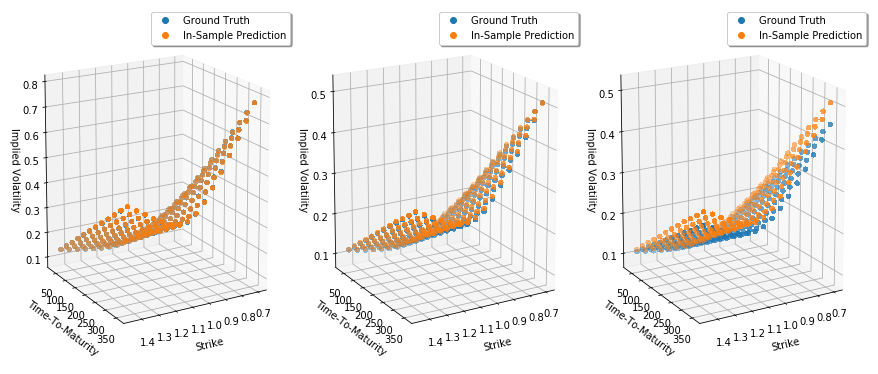

In [13]:
z = feature_extractor.autoencoder.encoder(torch.from_numpy(iv_data))
rec = feature_extractor.autoencoder.decoder(z).detach().numpy()

strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)

plot_data = {
    "iv_grid_1": iv_data[:],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_grid_2": rec[:],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms,
    "legend": ["Ground Truth","In-Sample Prediction"]
}

Plt = IV_Plotting_Helper(data=plot_data)

fig, inds_, mapes_ = Plt.plot_min_max_median_mape(view_angle=(15, 60), as_grid=True)
print(inds_)
print(mapes_)
plt.savefig("VAE_in_sample.pdf")

In [10]:
# save feature space data
data = np.genfromtxt(f"../data/test{test_id}_data_sabr_train.csv", delimiter=',').reshape((10000, 12, 16, 1)).astype('float32')
print("data shape:",data.shape)
feature_data = feature_extractor.produce_features(data)
print("feature data shape:",feature_data.shape)
feature_extractor.save_produced_features(f"latent_space_data/features_{test_id}_train")

data shape: (10000, 12, 16, 1)
feature data shape: (10000, 4)


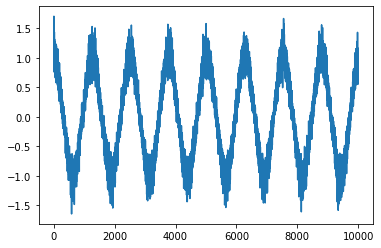

In [29]:
plt.plot(feature_data[:,2])

# Feature Prediction: Train Transformer

In [14]:
# load data and create data set with features
feature_data = np.genfromtxt(f"latent_space_data/features_{test_id}_train_vae_model", delimiter=',').astype('float32')[:10000,:]
print(feature_data.shape)

look_back = 50
num_data_points = feature_data.shape[0]
num_train_data_points = int(0.7*num_data_points)

transformer_model = Transformer_prediction_model(
    feature_data, 
    params={"look_back": look_back, "forecast_window": 200},
    decoder=feature_extractor.autoencoder.decoder,
    call_prices=call_data,
    strikes=strikes,
    ttms=ttms
)

(10000, 4)
Data shape with extra features:  (10000, 8)


In [131]:
# train the model
path = f"./models/deep_transformer/res{test_id}/"
best_model = transformer_model.transformer_no_dynamic_arbitrage(
    epochs=15, 
    path_to_save_model=path, 
    path_to_save_loss=path, 
    device="cpu",
    beta_feature_mse=0.
)
print(best_model)

Epoch: 0 , Call Grids MSE Loss: 0.006648773319366272
Epoch: 1 , Call Grids MSE Loss: 0.006426003247385189
Epoch: 2 , Call Grids MSE Loss: 0.006257909795335683
Epoch: 3 , Call Grids MSE Loss: 0.006147826620927191
Epoch: 4 , Call Grids MSE Loss: 0.005988541664099406
Epoch: 5 , Call Grids MSE Loss: 0.005866088367680886


KeyboardInterrupt: 

In [15]:
#path = f"./models/deep_transformer/res{test_id}/"
path = f"./models/deep_transformer/res{test_id}/"

best_model = "best_train_NDA_5.pth"
#best_model = "best_train_1.pth"

In [31]:
# Get in sample errors
in_sample_errors = transformer_model.in_sample_errors(path, best_model) 
print(in_sample_errors.shape)

(10000, 4)


## Make Predictions for new data

In [18]:
# Create feature data for new data
data_test = np.genfromtxt(f"../data/test{test_id}_data_sabr_test.csv", delimiter=',').reshape((600, 12, 16, 1)).astype('float32')
print("test data shape:",data_test.shape)
feature_data_test = feature_extractor.produce_features(data_test)
print("feature data test shape:",feature_data_test.shape)


test data shape: (600, 12, 16, 1)
feature data test shape: (600, 4)


### Inference on test data without training 

In [19]:
prediction_features = transformer_model.inference_with_new_data(feature_data_test, path, best_model)
print(prediction_features.shape)

Data shape with extra features:  (600, 8)
(200, 4)


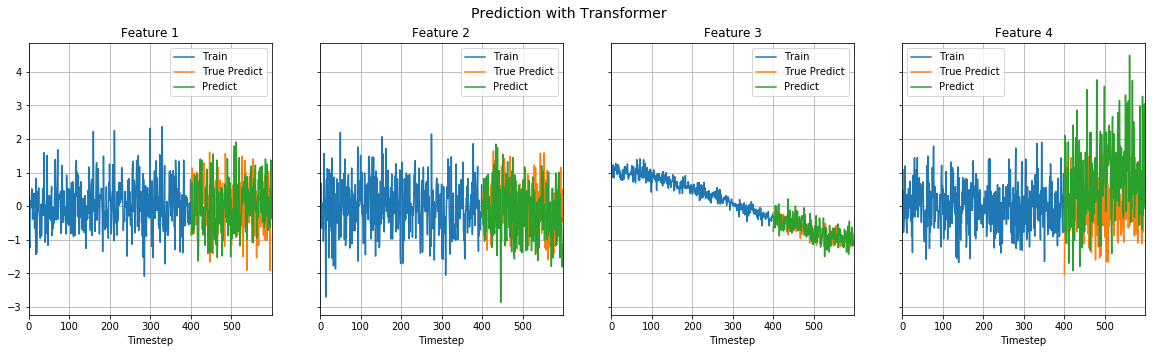

In [36]:
num_train_data_points = 600 - 200

true_ = feature_data_test[num_train_data_points:]

boot_strap_errors = in_sample_errors[np.random.randint(low=0, high=in_sample_errors.shape[0], size=true_.shape[0]),:]
#print(boot_strap_errors.shape)
pred_vec = prediction_features+boot_strap_errors
#pred_vec = prediction_features#+in_sample_errors[400:600]


fig = plot_features_with_prediction(
    data=feature_data_test[:num_train_data_points],
    prediction=pred_vec,
    true_predictions=true_,
    use_true_predictions=True,
    save_path_and_name=f"prediction_with_transformer_test{test_id}.pdf",
    params={
        "fig_title":"Prediction with Transformer",
        "share_y": True
    }
)

In [33]:
predicted_iv_grids = feature_extractor.create_iv_grids_from_features(pred_vec)
print(predicted_iv_grids.shape)

(200, 12, 16, 1)


(200, 12, 16)
(600, 12, 16, 1)
(200, 12, 16, 1)
[179, 77, 36]
[array([0.3521287], dtype=float32), array([2.3214715], dtype=float32), array([9.867588], dtype=float32)]


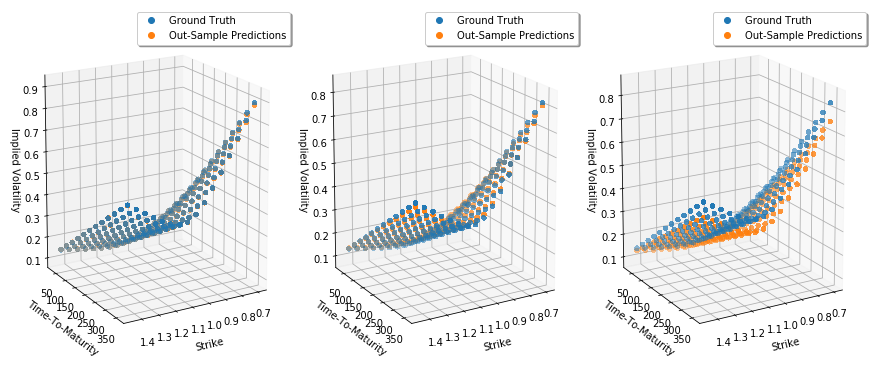

In [173]:
strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)

print(predicted_iv_grids[:,:,:,0].shape)
print(data_test.shape)


plot_data = {
    "iv_grid_1": data_test[600-200:,:,:,:],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_grid_2": predicted_iv_grids[:,:,:,:],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms,
    "legend": ["Ground Truth", "Out-Sample Predictions"]
}

Plt = IV_Plotting_Helper(data=plot_data)

#fig = Plt.plot_all_in_one(ind = 1, view_angle=(15, 30))

fig, inds_, mapes_ = Plt.plot_min_max_median_mape(view_angle=(15, 60), as_grid=True)
print(inds_)
print(mapes_)
plt.savefig("VAE_out_sample.pdf")

Text(0.5, 0, 'Timestep')

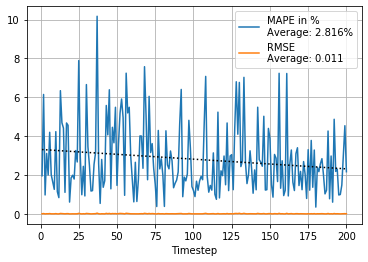

In [38]:
true_ivs = data_test[600-200:,:,:,0]
predicted_ivs = predicted_iv_grids[:,:,:,0]

mape = np.mean(np.abs(true_ivs-predicted_ivs)/ true_ivs, axis=(1,2))*100
rmse = np.sqrt(np.mean(np.power(true_ivs-predicted_ivs,2), axis=(1,2)))

x_ = np.arange(1,mape.shape[0]+1)


mean_mape = np.round(np.mean(mape)*1e3)/1e3
mean_rmse = np.round(np.mean(rmse)*1e3)/1e3

plt.plot(x_, mape, label=f"MAPE in % \nAverage: {mean_mape}%")
plt.plot(x_, rmse, label=f"RMSE \nAverage: {mean_rmse}")

plt.grid()

reg = np.polyfit(x_, mape, 1)
plt.plot(x_, reg[0]*x_+reg[1],  c="black", ls=":")
plt.legend()
#plt.ylabel("MAPE in %")
plt.xlabel("Timestep")
#plt.title("Predicted IV Grids to Ground Truth Test Data IV Grids")
#plt.savefig("MAPE_Predicted_epoch_13__beta_1.pdf")

### Inference on test data with training 

In [72]:
# train the model
path = f"./models/deep_transformer/res{test_id}/"
best_model_new, _ = transformer_model.transformer_no_dynamic_arbitrage_retrain_with_new_data(
    new_data=feature_data_test,
    trained_model=best_model,
    epochs=1, 
    path_to_save_model=path, 
    path_to_save_loss=path, 
    device="cpu"
)
print(best_model_new)

Data shape with extra features:  (600, 8)
Epoch: 0 , Call Grids MSE Loss: 0.00926945934251412
Epoch: 1 , Call Grids MSE Loss: 0.01355105689281066
best_train_NDA_trained_twice_0.pth


In [39]:
path = f"./models/deep_transformer/res{test_id}/"
best_model_new = "best_train_NDA_trained_twice_0.pth"

In [40]:
prediction_features_new = transformer_model.inference_with_new_data(feature_data_test, path, best_model_new)
print(prediction_features_new.shape)

Data shape with extra features:  (600, 8)
(200, 4)


(200, 4)


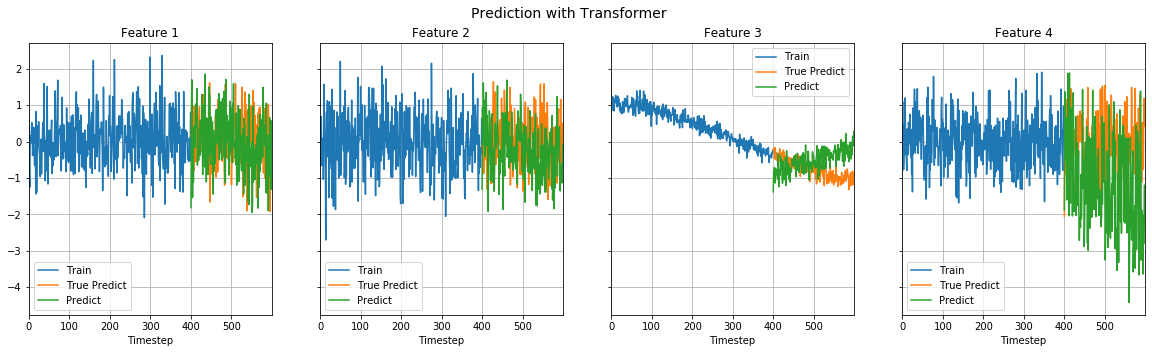

In [41]:
num_train_data_points = 600 - 200

true_ = feature_data_test[num_train_data_points:]

boot_strap_errors = in_sample_errors[np.random.randint(low=0, high=in_sample_errors.shape[0], size=true_.shape[0]),:]
print(boot_strap_errors.shape)
pred_vec_new = prediction_features_new+boot_strap_errors

fig = plot_features_with_prediction(
    data=feature_data_test[:num_train_data_points],
    prediction=pred_vec_new,
    true_predictions=true_,
    use_true_predictions=True,
    save_path_and_name=f"prediction_with_transformer_test{test_id}.pdf",
    params={
        "fig_title":"Prediction with Transformer",
        "share_y": True
    }
)

In [89]:
predicted_iv_grids_new = feature_extractor.create_iv_grids_from_features(pred_vec_new)
print(predicted_iv_grids_new.shape)

(200, 12, 16, 1)


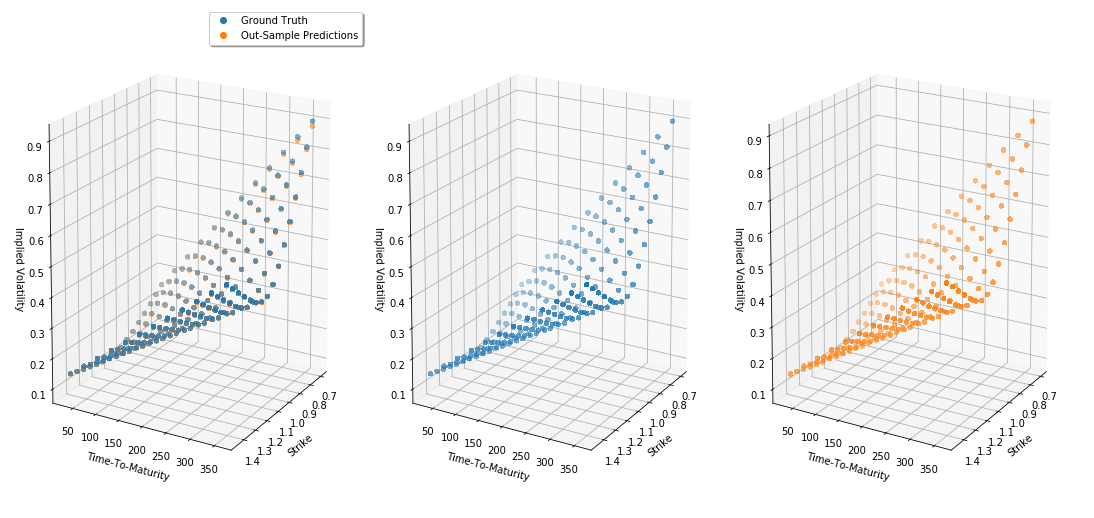

In [90]:
strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)


plot_data = {
    "iv_grid_1": data_test[600-200:],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_grid_2": predicted_iv_grids_new[:,:,:,0],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms,
    "legend": ["Ground Truth", "Out-Sample Predictions"]
}

Plt = IV_Plotting_Helper(data=plot_data)

fig = Plt.plot_all_in_one(ind = 179, view_angle=(15, 30))

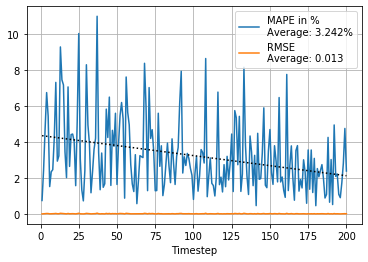

In [91]:
true_ivs = data_test[600-200:,:,:,0]
predicted_ivs_new = predicted_iv_grids_new[:,:,:,0]

mape = np.mean(np.abs(true_ivs-predicted_ivs_new)/ true_ivs, axis=(1,2))*100
rmse = np.sqrt(np.mean(np.power(true_ivs-predicted_ivs_new,2), axis=(1,2)))

x_ = np.arange(1,mape.shape[0]+1)


mean_mape = np.round(np.mean(mape)*1e3)/1e3
mean_rmse = np.round(np.mean(rmse)*1e3)/1e3

plt.plot(x_, mape, label=f"MAPE in % \nAverage: {mean_mape}%")
plt.plot(x_, rmse, label=f"RMSE \nAverage: {mean_rmse}")

plt.grid()

reg = np.polyfit(x_, mape, 1)
plt.plot(x_, reg[0]*x_+reg[1],  c="black", ls=":")
plt.legend()
#plt.ylabel("MAPE in %")
plt.xlabel("Timestep")
#plt.title("Predicted IV Grids to Ground Truth Test Data IV Grids \n With Training on First 400 Data Points of Test Data")
plt.savefig("MAPE_Predicted_2.pdf")

## NSA IVS DNN

In [20]:
# create nsa_ivs_dnn
strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)
beta = np.array([1e-5,1e-5,1e-5,1e1])

# same as data above but needs different shape
data_nsa_train = np.genfromtxt(f"../data/test{test_id}_data_sabr_test.csv", delimiter=',').astype('float32')
nsa_ivs = NSA_IVS_DNN(data_nsa_train, [strikes, ttms], (2,30,30), beta)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                5850      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 6,811
Trainable params: 6,811
Non-trainable params: 0
_________________________________________________________________


In [9]:
# train NSA DNN using training data
history = nsa_ivs.train(epochs=50)

# save NSA DNN
nsa_ivs.save_model(f"nsa_dnn_model{test_id}")

Epoch 1/50
600/600 [==============================] - 13s 21ms/step - total_loss: 4.4133 - reconstruction_loss: 4.2163 - nsa_C3: 0.0000e+00 - nsa_C4: 0.0000e+00 - nsa_C5: 0.0000e+00 - nsa_C6: 0.1969
Epoch 2/50
600/600 [==============================] - 11s 19ms/step - total_loss: 1.4297 - reconstruction_loss: 1.3262 - nsa_C3: 0.0000e+00 - nsa_C4: 0.0000e+00 - nsa_C5: 0.0000e+00 - nsa_C6: 0.1035 6s - total_
Epoch 3/50
600/600 [==============================] - 11s 18ms/step - total_loss: 1.1542 - reconstruction_loss: 1.0636 - nsa_C3: 0.0000e+00 - nsa_C4: 0.0000e+00 - nsa_C5: 0.0000e+00 - nsa_C6: 0.0906
Epoch 4/50
600/600 [==============================] - 12s 20ms/step - total_loss: 1.0076 - reconstruction_loss: 0.9242 - nsa_C3: 0.0000e+00 - nsa_C4: 0.0000e+00 - nsa_C5: 0.0000e+00 - nsa_C6: 0.0834
Epoch 5/50
600/600 [==============================] - 11s 19ms/step - total_loss: 0.9221 - reconstruction_loss: 0.8452 - nsa_C3: 0.0000e+00 - nsa_C4: 0.0000e+00 - nsa_C5: 0.0000e+00 - nsa_C6: 

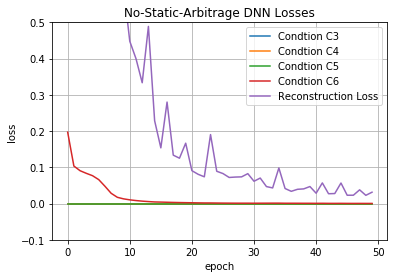

In [10]:
from matplotlib import pyplot as plt

"""
beta=[1e-1,1e-1,1e-1,1e-1]: 
total_loss: 0.1009 - reconstruction_loss: 0.0180 - nsa_C3: 0.0000e+00 - nsa_C4: 0.0000e+00 - nsa_C5: 0.0000e+00 - nsa_C6: 0.0829
beta=[1e-1,1e-1,1e-1,1e0]: 
total_loss: 0.0188 - reconstruction_loss: 0.0175 - nsa_C3: 0.0000e+00 - nsa_C4: 0.0000e+00 - nsa_C5: 0.0000e+00 - nsa_C6: 0.0014
beta=[1e-3,1e-3,1e-3,1e1]:
total_loss: 0.0190 - reconstruction_loss: 0.0188 - nsa_C3: 0.0000e+00 - nsa_C4: 0.0000e+00 - nsa_C5: 0.0000e+00 - nsa_C6: 1.4369e-04
beta=[1e-6,1e-6,1e-6,1e1]
total_loss: 0.0317 - reconstruction_loss: 0.0313 - nsa_C3: 0.0000e+00 - nsa_C4: 0.0000e+00 - nsa_C5: 0.0000e+00 - nsa_C6: 3.6923e-04
"""

plt.plot(history.history['nsa_C3'])
plt.plot(history.history['nsa_C4'])
plt.plot(history.history['nsa_C5'])
plt.plot(history.history['nsa_C6'])
plt.plot(history.history['reconstruction_loss'])
#plt.plot(history.history['total_loss'], ls=':', c='black')
plt.title('No-Static-Arbitrage DNN Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['Condtion C3','Condtion C4','Condtion C5','Condtion C6','Reconstruction Loss', 'Total Loss'], loc='upper right')
plt.legend(['Condtion C3','Condtion C4','Condtion C5','Condtion C6','Reconstruction Loss'], loc='upper right')

plt.grid()
#plt.yscale("log")
#plt.ylim(1e-9,1e9)
plt.ylim(-0.1,0.5)

#plt.show()
plt.savefig("nsa_dnn_losses_4.pdf")

In [21]:
# load NSA DNN
nsa_ivs.load_model(f"nsa_dnn_model{test_id}")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 30)                5850      
_________________________________________________________________
dense_7 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 6,811
Trainable params: 6,811
Non-trainable params: 0
_________________________________________________________________


In [22]:
#  create surfaces

strikes_test = np.arange(0.65, 1.55, 0.04)
ttms_test = np.arange(15, 415, 15)

in_sample_nsa_ivs = nsa_ivs.predict_all_surfaces(data_nsa_train, strikes_test, ttms_test)

In [23]:
strikes = np.arange(0.7, 1.5, 0.05)
#ttms = np.arange(1, 13, 1)
ttms = np.arange(30, 390, 30)

legend = ["NSA DNN Test Predictions", "Ground Truth"]

plot_data = {
    "iv_grid_1": data_nsa_train,
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_surface_1": in_sample_nsa_ivs,
    "stikes_surface_1": strikes_test,
    "ttms_surface_1": ttms_test,
    "legend": legend
}

Plt_1 = IV_Plotting_Helper(data=plot_data)

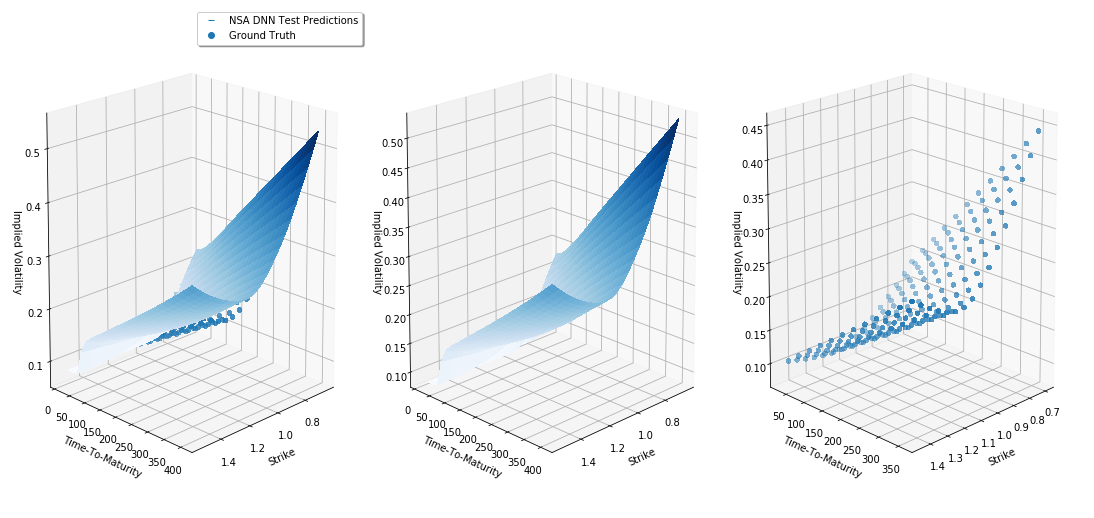

In [24]:
fig = Plt_1.plot_all_in_one(ind = 0, view_angle=(15, 45))

In [42]:
strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)

nsa_ivs_for_predictions = nsa_ivs.predict_all_surfaces(predicted_iv_grids[:,:,:,0], strikes_test, ttms_test)

legend = ["NSA IVS for Ground Truth", "NSA IVS for Prediction", "Ground Truth Grid", "Predicted Grid"]

plot_data = {
    "iv_grid_1": data_nsa_train[600-180:],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_surface_1": in_sample_nsa_ivs[600-180:],
    "stikes_surface_1": strikes_test,
    "ttms_surface_1": ttms_test,
    "iv_grid_2": predicted_iv_grids[:,:,:,0],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms,
    "iv_surface_2": nsa_ivs_for_predictions,
    "stikes_surface_2": strikes_test,
    "ttms_surface_2": ttms_test,
    "legend": legend
}

Plt_2 = IV_Plotting_Helper(data=plot_data)

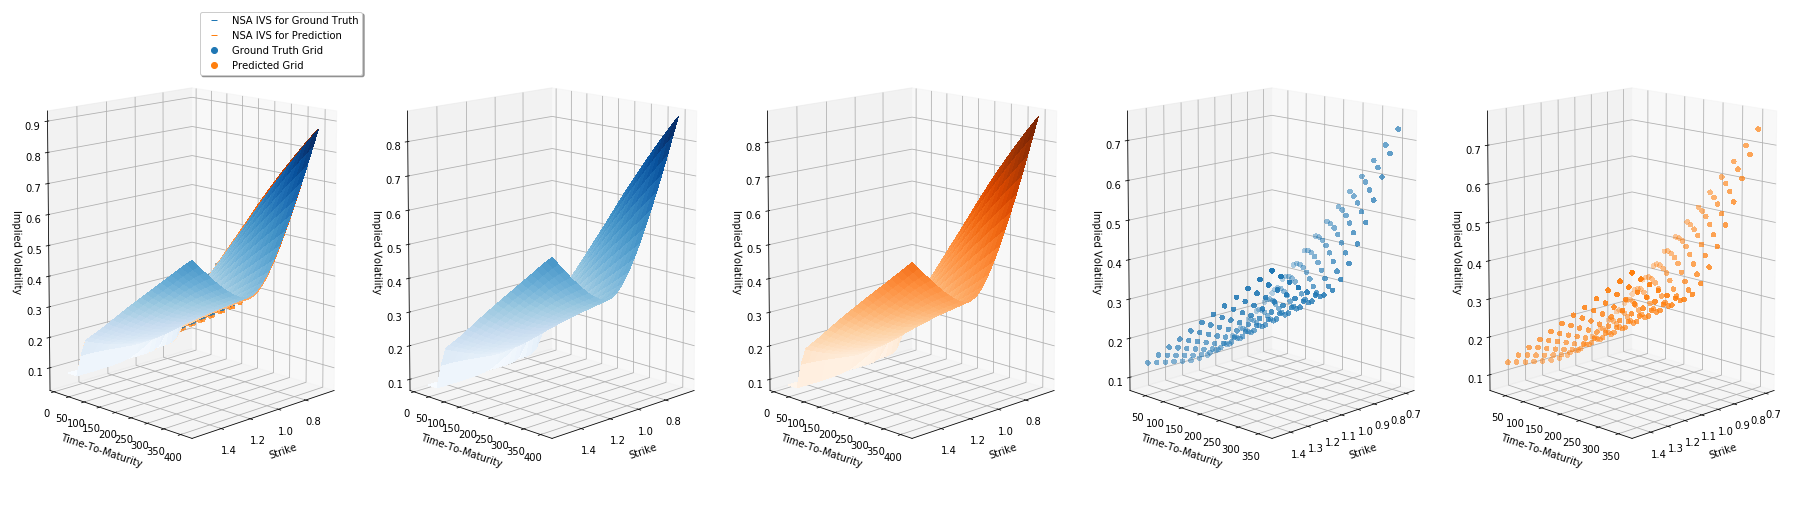

In [235]:
fig = Plt_2.plot_all_in_one(ind = 1, view_angle=(10, 45))
plt.savefig("nsda_iv_example.pdf")

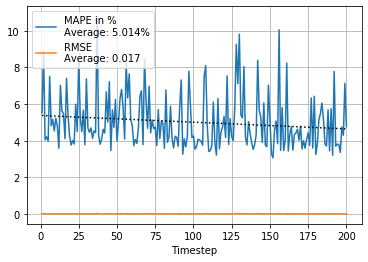

In [43]:
import matplotlib.pyplot as plt

true_ivs = data_test[600-200:,:,:,0]
predicted_iv_surfaces = nsa_ivs.predict_all_surfaces(predicted_iv_grids[:,:,:,0], strikes, ttms)

mape = np.mean(np.abs(true_ivs-predicted_iv_surfaces)/ true_ivs, axis=(1,2))*100
rmse = np.sqrt(np.mean(np.power(true_ivs-predicted_iv_surfaces,2), axis=(1,2)))

x_ = np.arange(1,mape.shape[0]+1)

mean_mape = np.round(np.mean(mape)*1e3)/1e3
mean_rmse = np.round(np.mean(rmse)*1e3)/1e3

plt.plot(x_, mape, label=f"MAPE in % \nAverage: {mean_mape}%")
plt.plot(x_, rmse, label=f"RMSE \nAverage: {mean_rmse}")
plt.grid()

reg = np.polyfit(x_, mape, 1)
plt.plot(x_, reg[0]*x_+reg[1],  c="black", ls=":")
plt.legend()
#plt.ylabel("MAPE in %")
plt.xlabel("Timestep")
#plt.title("No-Static-Arbitrage Predictions using Predicted IV Grids \n To Ground Truth Test Data IV Grids")
plt.savefig("MAPE_NSA_Predicted.pdf")

In [26]:
strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)

print(predicted_iv_surfaces.shape)

plot_data = {
    "iv_grid_1": data_test[600-200:,:,:,:],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_surface_1": predicted_iv_surfaces.reshape((200, 12, 16, 1)),
    "stikes_surface_1": strikes,
    "ttms_surface_1": ttms,
    "legend": ["Ground Truth", "NSA IVS for Prediction"]
}

Plt = IV_Plotting_Helper(data=plot_data)

#fig = Plt.plot_all_in_one(ind = 1, view_angle=(15, 30))

fig, inds_, mapes_ = Plt.plot_min_max_median_mape(view_angle=(15, 60), as_grid=False)
print(inds_)
print(mapes_)
plt.savefig("VAE_nsa_dnn_out_sample.pdf")

NameError: name 'predicted_iv_surfaces' is not defined

In [238]:
#Test for NSA Conditions for predicted implied vol surfaceses
ind = 1

violations = nsa_ivs.nsa_dnn.test_for_conditions(predicted_iv_surfaces[ind,:,:].flatten(), strikes_test, ttms_test)
#violations = nsa_ivs.nsa_dnn.test_for_conditions(predicted_iv_surfaces[ind,:,:].flatten(), np.arange(0.6, 1.6, 0.3), np.arange(15, 415, 90))

print([i.numpy()[0] for i in violations])

[0.0, 0.0, 0.0, 2.2365118e-06]


(200,)


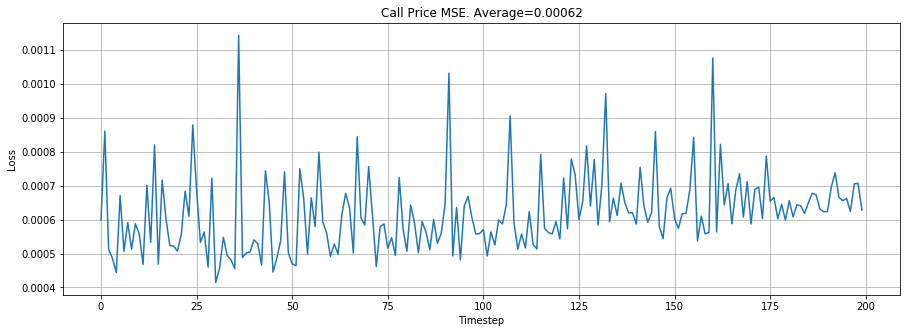

In [44]:
true_ivs_ = data_test[600-200:,:,:,:]
predicted_ivs_ = predicted_iv_surfaces.reshape((200, 12, 16, 1))

strikes_ = np.tile(np.array([strikes]), (ttms.shape[0],1))
ttms_ = np.tile(np.array([ttms]), (strikes.shape[0],1)).T

true_calls_ = np.zeros_like(true_ivs_)
predicted_calls_ = np.zeros_like(predicted_ivs_)

for i in range(200):
    true_calls_[i,:,:,0] = black_scholes_call(S=torch.tensor([1.]), K=strikes_, tau=ttms_, r=torch.tensor([0.]), sigma=true_ivs_[i,:,:,0])
    predicted_calls_[i,:,:,0] = black_scholes_call(S=torch.tensor([1.]), K=strikes_, tau=ttms_, r=torch.tensor([0.]), sigma=predicted_ivs_[i,:,:,0])

call_mses = np.mean((true_calls_-predicted_calls_)**2,axis=(1,2,3))
print(call_mses.shape)

call_mses_avg = np.mean(call_mses)

plt.figure(figsize=(15,5))
plt.plot(call_mses)
plt.grid(True)
plt.ylabel('Loss')
plt.title(f"Call Price MSE. Average={np.round(call_mses_avg,5)}")
plt.xlabel("Timestep")
plt.savefig("call_price_MSE__prediction.pdf")

Some parameters missing!
151
3.0709952080433185


AttributeError: 'IV_Plotting_Helper' object has no attribute 'stikes_surface_1'

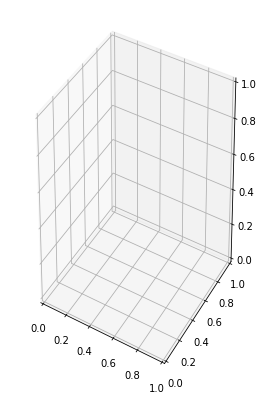

In [196]:
strikes = np.arange(0.7, 1.5, 0.05)
#ttms = np.arange(1, 13, 1)
ttms = np.arange(30, 390, 30)

legend = ["NSA DNN Test Predictions", "Ground Truth"]



plot_data = {
    "iv_grid_1": true_ivs,
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_surface_1": nsa_ivs_for_predictions,
    "stikes_surface_2": strikes_test,
    "ttms_surface_2": ttms_test,
    "legend": legend
}

Plt_1 = IV_Plotting_Helper(data=plot_data)

print(np.argmin(mape))
print(np.min(mape))

fig = Plt_1.plot_all_in_one(ind = np.argmax(mape), view_angle=(10, 50))
plt.savefig("MAPE_MAX.pdf")

#max ind 57, mape 9.752934426598452

#min ind 76, mape 1.3437930290336673